# 导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import missingno as msno
import operator
import numpy as np
import seaborn as sns
import random
from scipy.stats import norm, gamma
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as AC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve as ROC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 1.数据初步探索

## 1.1获取数据并划分数据集

In [2]:
data = pd.read_csv("C:/Users/Gift_OYS/Desktop/clinvar_conflicting.csv")

In [3]:
#将特征矩阵和标签Y分开
X = data[data.columns[data.columns!='CLASS']]
Y = data['CLASS']
#分训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3,random_state=666)

df_train = data.loc[Xtrain.index.to_list()]
df_test = data.loc[Xtest.index.to_list()]

#恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest, df_train, df_test]:
    i.index = range(i.shape[0])

## 1.2数据整体分析

### 1.2.1数据描述性统计

In [4]:
print(Xtrain.shape, Xtest.shape)

(45631, 45) (19557, 45)


In [5]:
# 查看数据的列
Xtrain.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNDISDB',
       'CLNDISDBINCL', 'CLNDN', 'CLNDNINCL', 'CLNHGVS', 'CLNSIGINCL', 'CLNVC',
       'CLNVI', 'MC', 'ORIGIN', 'SSR', 'Allele', 'Consequence', 'IMPACT',
       'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON',
       'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids',
       'Codons', 'DISTANCE', 'STRAND', 'BAM_EDIT', 'SIFT', 'PolyPhen',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE',
       'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62'],
      dtype='object')

In [6]:
# 查看数据基本信息
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45631 entries, 0 to 45630
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               45631 non-null  object 
 1   POS                 45631 non-null  int64  
 2   REF                 45631 non-null  object 
 3   ALT                 45631 non-null  object 
 4   AF_ESP              45631 non-null  float64
 5   AF_EXAC             45631 non-null  float64
 6   AF_TGP              45631 non-null  float64
 7   CLNDISDB            45631 non-null  object 
 8   CLNDISDBINCL        122 non-null    object 
 9   CLNDN               45631 non-null  object 
 10  CLNDNINCL           122 non-null    object 
 11  CLNHGVS             45631 non-null  object 
 12  CLNSIGINCL          122 non-null    object 
 13  CLNVC               45631 non-null  object 
 14  CLNVI               19384 non-null  object 
 15  MC                  45045 non-null  object 
 16  ORIG

In [7]:
#描述性统计
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
POS,45631.0,7.753149e+07,5.961475e+07,961.000000,3.264741e+07,5.793547e+07,1.128882e+08,2.476074e+08
AF_ESP,45631.0,1.450075e-02,5.773474e-02,0.000000,0.000000e+00,0.000000e+00,1.300000e-03,4.989000e-01
AF_EXAC,45631.0,1.463249e-02,5.987692e-02,0.000000,0.000000e+00,5.000000e-05,1.270000e-03,4.997400e-01
AF_TGP,45631.0,1.549651e-02,6.018867e-02,0.000000,0.000000e+00,0.000000e+00,1.600000e-03,4.998000e-01
ORIGIN,45631.0,1.353619e+00,6.094317e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,5.130000e+02
SSR,89.0,2.348315e+00,4.314619e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01
DISTANCE,77.0,8.201688e+02,1.094722e+03,1.000000,5.600000e+01,4.720000e+02,1.407000e+03,4.759000e+03
STRAND,45621.0,-9.096688e-03,9.999696e-01,-1.000000,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
MOTIF_POS,2.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
MOTIF_SCORE_CHANGE,2.0,-8.000000e-02,2.404163e-02,-0.097000,-8.850000e-02,-8.000000e-02,-7.150000e-02,-6.300000e-02


In [8]:
#描述性统计
Xtest.describe().T

,count,mean,std,min,25%,50%,75%,max
POS,19557.0,7.767964e+07,6.003432e+07,1393.000000,3.240088e+07,5.810923e+07,1.125811e+08,2.476080e+08
AF_ESP,19557.0,1.453333e-02,5.793818e-02,0.000000,0.000000e+00,0.000000e+00,1.200000e-03,4.990000e-01
AF_EXAC,19557.0,1.416479e-02,5.875367e-02,0.000000,0.000000e+00,4.000000e-05,1.140000e-03,4.998900e-01
AF_TGP,19557.0,1.471983e-02,5.795307e-02,0.000000,0.000000e+00,0.000000e+00,1.400000e-03,4.976000e-01
ORIGIN,19557.0,1.316511e+00,4.605754e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,5.130000e+02
SSR,41.0,2.097561e+00,3.954775e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01
DISTANCE,31.0,8.395484e+02,1.020957e+03,1.000000,4.500000e+01,4.660000e+02,1.530500e+03,4.402000e+03
STRAND,19553.0,-9.717179e-04,1.000025e+00,-1.000000,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
MOTIF_POS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MOTIF_SCORE_CHANGE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#查看重复值
print(Xtrain.duplicated().sum())

0


### 1.2.2缺失值查看

In [10]:
# 查看缺失特征的数量
Xtrain.isnull().any().sum()

30

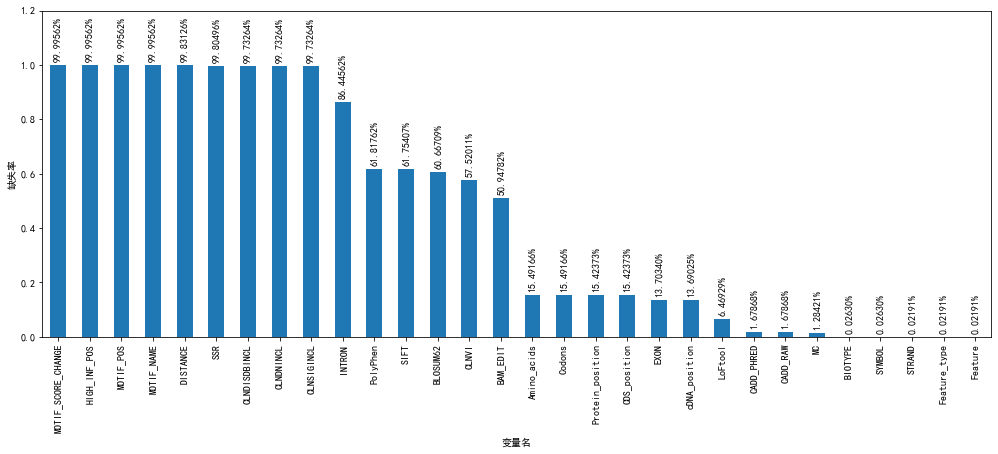

In [11]:
# 统计缺失率
missing = Xtrain.isnull().sum() / len(Xtrain)
plt.figure(figsize=(17,6))
missing[missing != 0].sort_values(ascending = False,inplace = False).plot.bar()
plt.xlabel('变量名')
plt.ylabel('缺失率')
plt.ylim([0, 1.2])
# 添加数值显示
for x, y in enumerate(missing[missing != 0].sort_values(ascending = False,inplace = False)):
    plt.text(x,y+0.015,'{:.5%}'.format(y),ha='center',rotation=90)
plt.show()

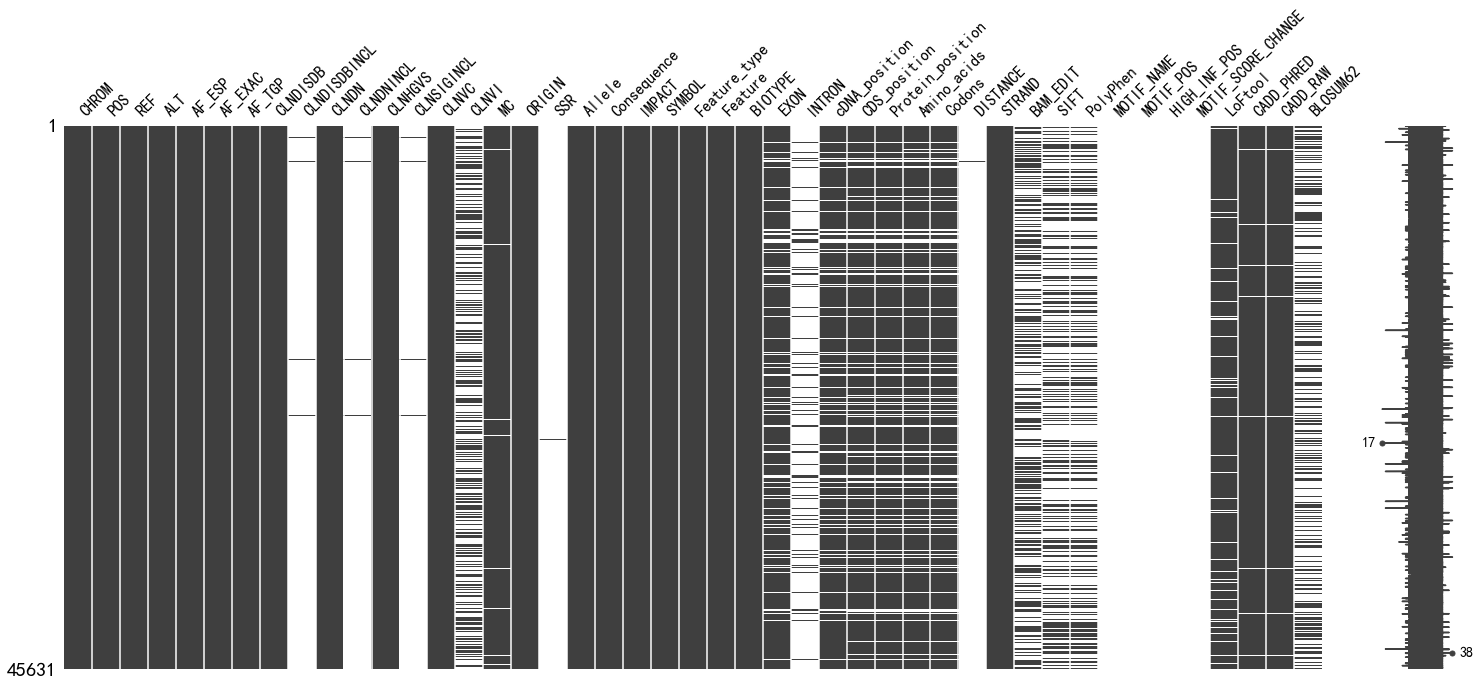

In [12]:
msno.matrix(Xtrain)
plt.show()

### 1.2.3唯一值查看

In [13]:
# 查看唯一值
print([col for col in Xtrain.columns if Xtrain[col].nunique() <= 1])
print([col for col in Xtest.columns if Xtest[col].nunique() <= 1])

['MOTIF_POS', 'HIGH_INF_POS']
['Feature_type', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE']


In [14]:
print(Xtrain['MOTIF_POS'][0], Xtrain['HIGH_INF_POS'][0])
print(Xtest['MOTIF_POS'][0], Xtest['HIGH_INF_POS'][0])

nan nan
nan nan


# 2.数据可视化分析

## 2.1单一变量分析

### 2.1.1探索标签分布

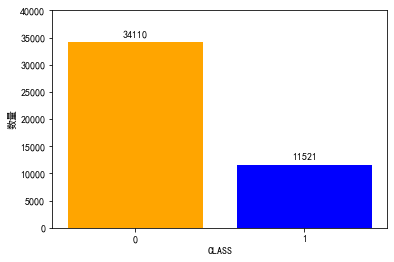

In [15]:
# 探索标签的分布
CLASS_1 = (Ytrain==1).sum()
CLASS_0 = (Ytrain==0).sum()
plt.bar([0,1], [CLASS_0, CLASS_1], color=['orange','blue'])
plt.xticks([0,1], ['0', '1'])  
plt.xlabel("CLASS") 
plt.ylabel('数量')
plt.ylim([0, 40000])
# 添加数值显示
for x, y in enumerate([CLASS_0, CLASS_1]):
    plt.text(x,y+1000,'{:}'.format(y),ha='center')

### 2.1.2 探索特征整体分布

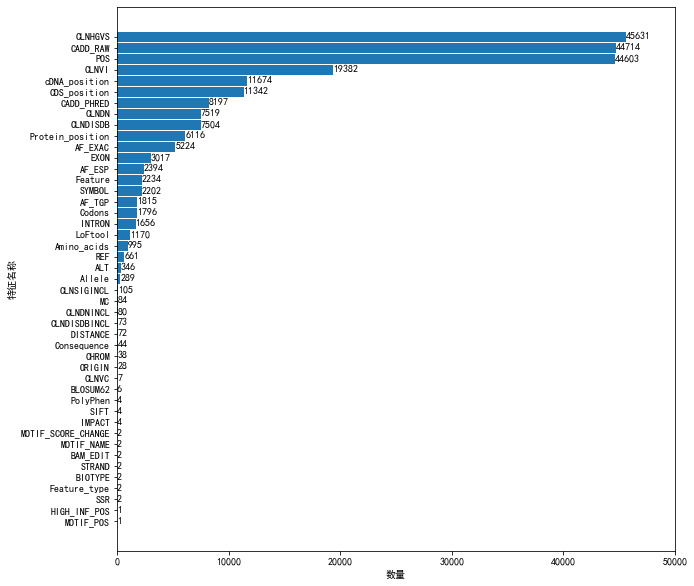

In [16]:
# 探索特征取值的数量
dic = {}
cols = Xtrain.columns
for i in range(len(cols)):
    col = cols[i]
    nums = Xtrain[col].drop_duplicates().count()
    dic[col] = nums
res = sorted(dic.items(), key=operator.itemgetter(1))
k = []
v = []
for i in range(len(res)):
    k.append(res[i][0])
    v.append(res[i][1])
plt.figure(figsize=(10,10))
b = plt.barh(k, v, height=0.9)
plt.xlim([0, 50000])
plt.xlabel("数量") 
plt.ylabel('特征名称')
for rect in b:
    w=rect.get_width()
    plt.text(w,rect.get_y()+rect.get_height()/1.8,'%d'%w,ha='left',va='center')

In [17]:
# 筛选数值型特征
numerical_fea = list(Xtrain.select_dtypes(exclude=['object']).columns)
# 筛选分类型变量
category_fea = list(filter(lambda x: x not in numerical_fea,list(Xtrain.columns)))

([<matplotlib.patches.Wedge at 0x21607aabc70>,
 [Text(0.6151121615623577, 0.9119413515671302, '数值型'),
  Text(-0.6151120761802438, -0.911941409158083, '非数值型')],
 [Text(0.3355157244885587, 0.49742255540025276, '31.11%'),
  Text(-0.33551567791649656, -0.49742258681349977, '68.89%')])

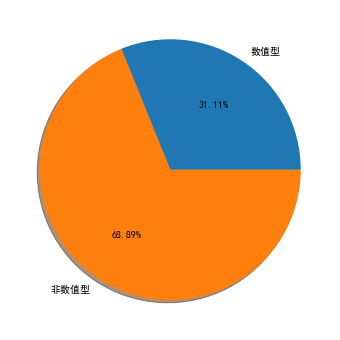

In [18]:
numer = len(numerical_fea)
categ = len(category_fea)
plt.figure(figsize=(6,6))
plt.pie(x=[numer, categ],labels=['数值型', '非数值型'],autopct='%3.2f%%',shadow=True)

### 2.1.3探索部分分类型变量

#### 探索CLNVC

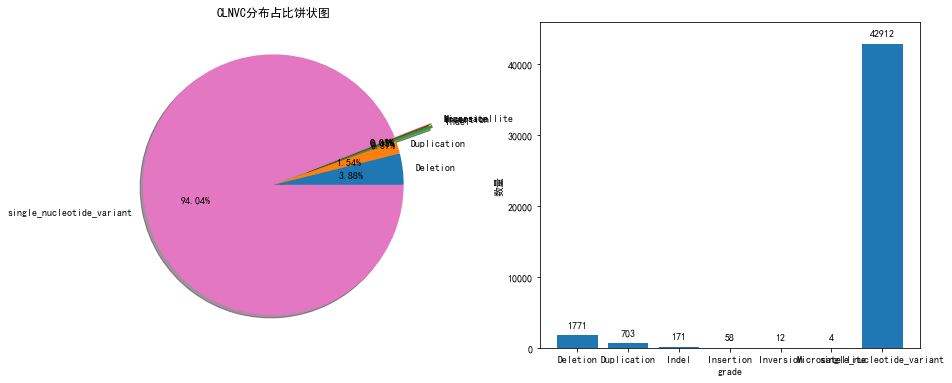

In [19]:
# 探索CLNVC的数量分布
g = np.sort(Xtrain["CLNVC"].drop_duplicates().values)
g_cnt = [len(Xtrain[Xtrain['CLNVC']==g[i]]) for i in range(len(g))]

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('CLNVC分布占比饼状图')
explode = (0,0,0.3,0.3,0.3,0.3,0)
plt.pie(x=g_cnt,labels=g,autopct='%3.2f%%',shadow=True,explode=explode)
plt.subplot(1, 2, 2)
plt.bar(g, g_cnt)
plt.ylim([0, 46000])
plt.xlabel("grade") 
plt.ylabel('数量')
for x, y in enumerate(g_cnt):
    plt.text(x,y+1000,'{:}'.format(y),ha='center')

#### 探索CHROM

In [20]:
# 探索CHROM的数量分布
g = Xtrain["CHROM"].drop_duplicates().values
g

array([2, '8', '1', 16, 15, '9', '7', '5', '10', 17, '11', 19, '6', 14,
       13, 18, 'X', 3, '17', '3', '16', 12, '4', 20, 21, '14', '13', '19',
       22, '15', '12', '2', '21', 11, '18', 'MT', '22', '20'],
      dtype=object)

In [21]:
for i in range(len(Xtrain['CHROM'])):
    Xtrain['CHROM'][i] = str(Xtrain['CHROM'][i])
g = Xtrain["CHROM"].drop_duplicates().values
g

array(['2', '8', '1', '16', '15', '9', '7', '5', '10', '17', '11', '19',
       '6', '14', '13', '18', 'X', '3', '12', '4', '20', '21', '22', 'MT'],
      dtype=object)

In [22]:
for i in range(len(Xtest['CHROM'])):
    Xtest['CHROM'][i] = str(Xtest['CHROM'][i])
g = Xtest["CHROM"].drop_duplicates().values
g

array(['17', '2', '6', '13', '22', '19', '18', '8', '10', '1', '15', '9',
       '11', '12', 'X', '16', '3', '7', '4', '14', '5', '21', '20', 'MT'],
      dtype=object)

In [23]:
for i in range(len(df_train['CHROM'])):
    df_train['CHROM'][i] = str(df_train['CHROM'][i])
for i in range(len(df_test['CHROM'])):
    df_test['CHROM'][i] = str(df_test['CHROM'][i])

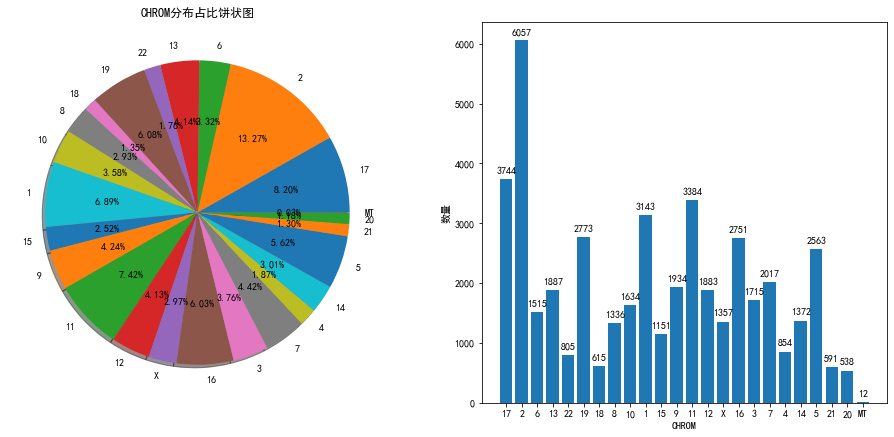

In [24]:
g_cnt = [len(Xtrain[Xtrain['CHROM']==g[i]]) for i in range(len(g))]
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.title('CHROM分布占比饼状图')
plt.pie(x=g_cnt,labels=g,autopct='%3.2f%%',shadow=True)
plt.subplot(1, 2, 2)
plt.bar(g, g_cnt)
plt.xlabel("CHROM") 
plt.ylabel('数量')
for x, y in enumerate(g_cnt):
    plt.text(x,y+90,'{:}'.format(y),ha='center')

#### 探索Consequence

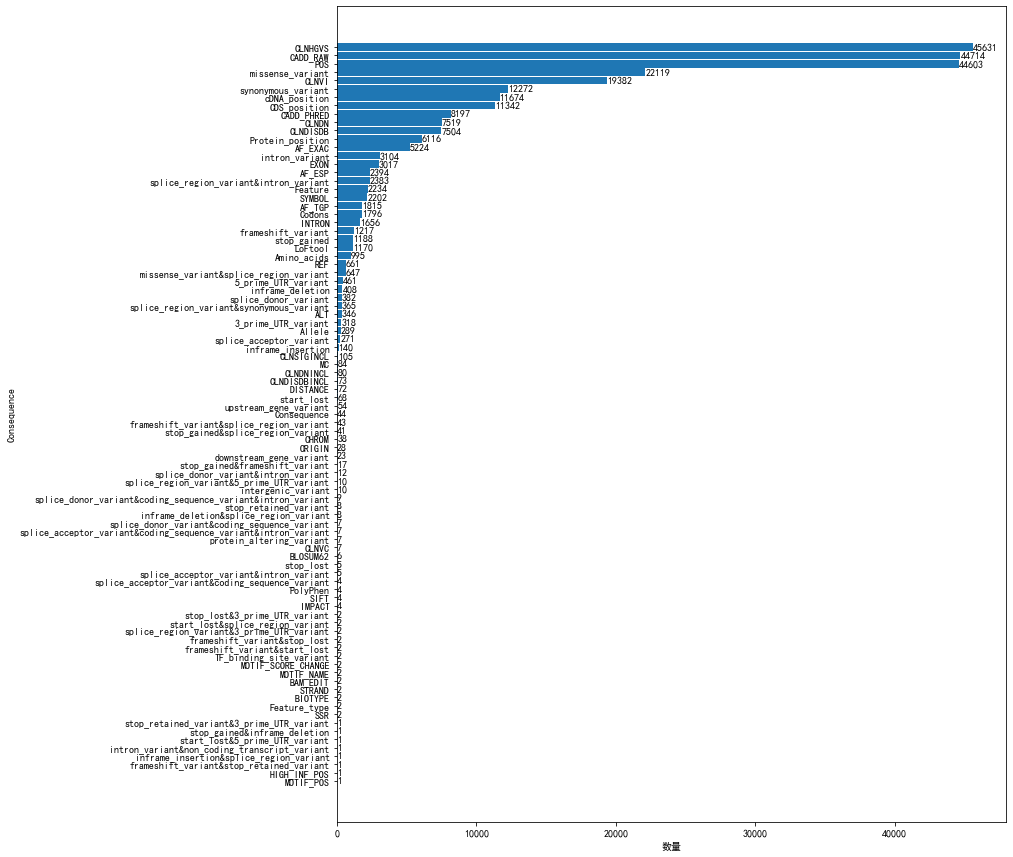

In [25]:
# 探索Consequence的数量分布
g = np.sort(Xtrain["Consequence"].drop_duplicates().values)
g_cnt = [len(Xtrain[Xtrain['Consequence']==g[i]]) for i in range(len(g))]
for i in range(len(g)):
    col = g[i]
    dic[col] = g_cnt[i]
res = sorted(dic.items(), key=operator.itemgetter(1))
k = []
v = []
for i in range(len(res)):
    k.append(res[i][0])
    v.append(res[i][1])
plt.figure(figsize=(12,15))
b = plt.barh(k, v, height=0.9)
plt.xlim([0, 48000])
plt.xlabel("数量") 
plt.ylabel('Consequence')
for rect in b:
    w=rect.get_width()
    plt.text(w,rect.get_y()+rect.get_height()/1.8,'%d'%w,ha='left',va='center')

#### 探索ORIGIN

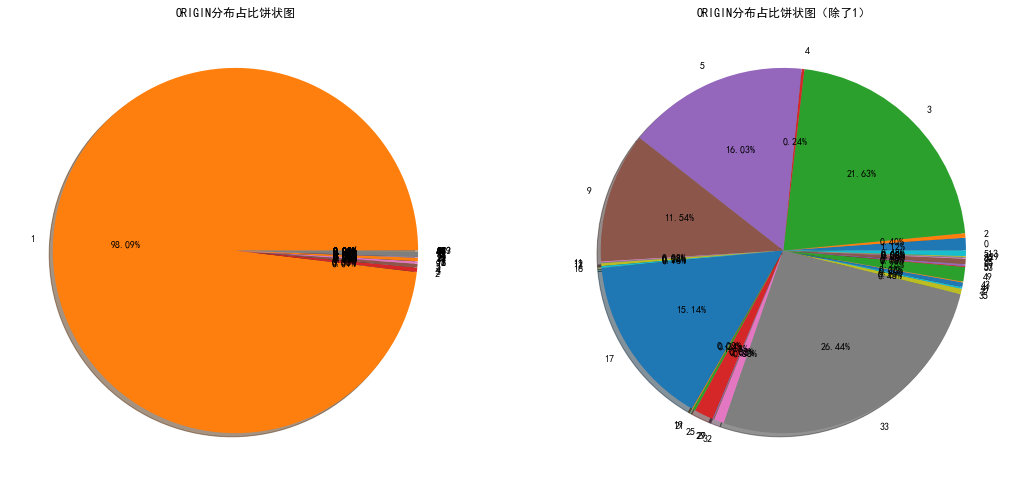

In [26]:
# 探索ORIGIN的数量分布
plt.figure(figsize=(18,9))
plt.subplot(1, 2, 1)
g = np.sort(Xtrain["ORIGIN"].drop_duplicates().values)
g_cnt = [len(Xtrain[Xtrain['ORIGIN']==g[i]]) for i in range(len(g))]
plt.title('ORIGIN分布占比饼状图')
plt.pie(x=g_cnt,labels=g,autopct='%3.2f%%',shadow=True)

plt.subplot(1, 2, 2)
g = np.sort(data["ORIGIN"].drop_duplicates().values)
g = np.delete(g, [1])
g_cnt = [len(data[data['ORIGIN']==g[i]]) for i in range(len(g))]
plt.title('ORIGIN分布占比饼状图（除了1）')
plt.pie(x=g_cnt,labels=g,autopct='%3.2f%%',shadow=True)
plt.show()

### 2.1.4探索部分连续型变量

#### 探索POS 

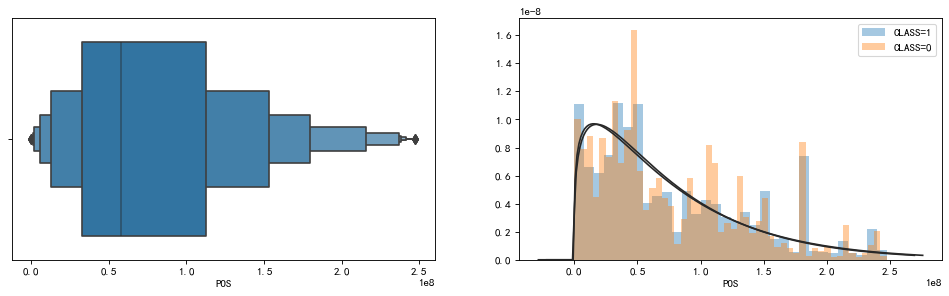

In [27]:
plt.figure(6, figsize=(15,4), dpi=80)
plt.subplot(1, 2, 1)
sns.boxenplot(x=data['POS'])
plt.subplot(1, 2, 2)
sns.distplot(df_train.loc[df_train['CLASS']==1]['POS'], kde=False, fit=gamma, label="CLASS=1")
sns.distplot(df_train.loc[df_train['CLASS']==0]['POS'], kde=False, fit=gamma, label="CLASS=0")
plt.legend()

#### 探索CADD_PHRED

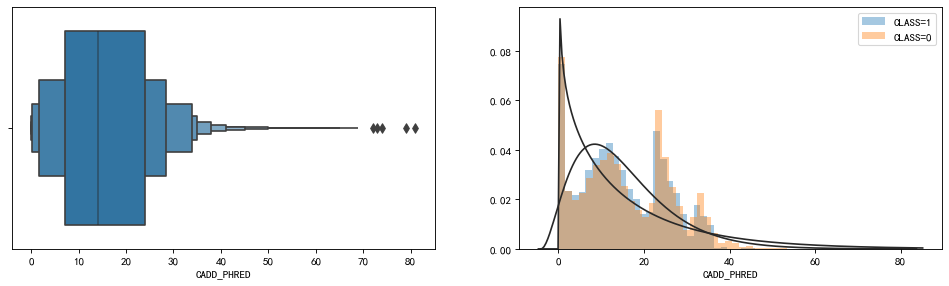

In [28]:
plt.figure(6, figsize=(15,4), dpi=80)
plt.subplot(1, 2, 1)
sns.boxenplot(x=df_train['CADD_PHRED'])
plt.subplot(1, 2, 2)
sns.distplot(df_train.loc[df_train['CLASS']==1]['CADD_PHRED'], kde=False, fit=gamma, label="CLASS=1")
sns.distplot(df_train.loc[df_train['CLASS']==0]['CADD_PHRED'], kde=False, fit=gamma, label="CLASS=0")
plt.legend()

#### 探索CADD_RAW

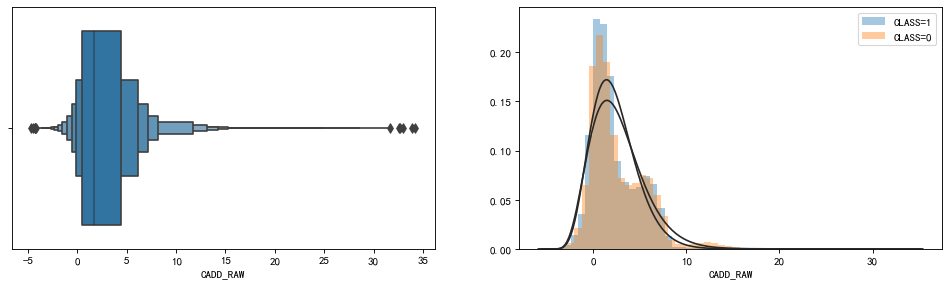

In [29]:
plt.figure(6, figsize=(15,4), dpi=80)
plt.subplot(1, 2, 1)
sns.boxenplot(x=df_train['CADD_RAW'])
plt.subplot(1, 2, 2)
sns.distplot(df_train.loc[df_train['CLASS']==1]['CADD_RAW'], kde=False, fit=gamma, label="CLASS=1")
sns.distplot(df_train.loc[df_train['CLASS']==0]['CADD_RAW'], kde=False, fit=gamma, label="CLASS=0")
plt.legend()

## 2.2双变量分析

### 2.2.1探索样本分布与冲突率

#### 探索CLNVC与冲突率

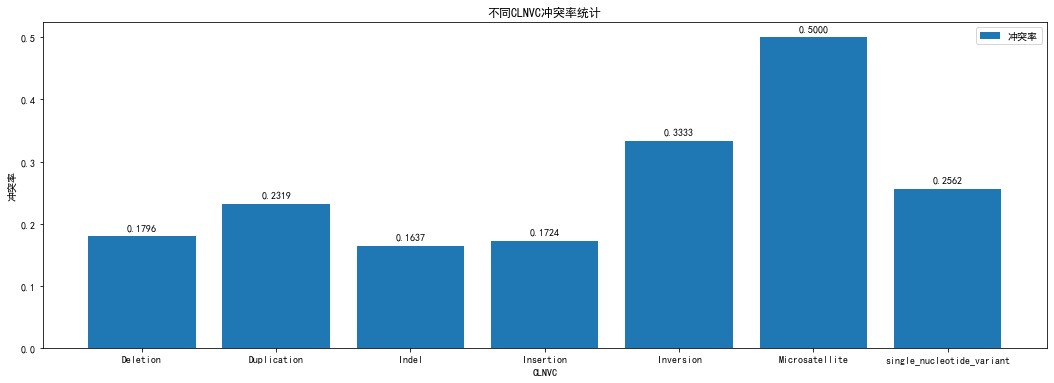

In [30]:
# 探索CLNVC与冲突率
sg = np.sort(df_train["CLNVC"].drop_duplicates().values)
sg_mr = [len(df_train[df_train['CLNVC']==sg[i]][df_train['CLASS']==1])/len(df_train[df_train['CLNVC']==sg[i]]) for i in range(len(sg))]
plt.figure(figsize=(18,6))
plt.bar(sg, sg_mr, label="冲突率")
plt.legend()
plt.title('不同CLNVC冲突率统计')
plt.xlabel('CLNVC')
plt.ylabel('冲突率')
for x, y in enumerate(sg_mr):
    plt.text(x,y+0.01,'{:.4f}'.format(y),ha='center')

#### 探索CHROM与冲突率

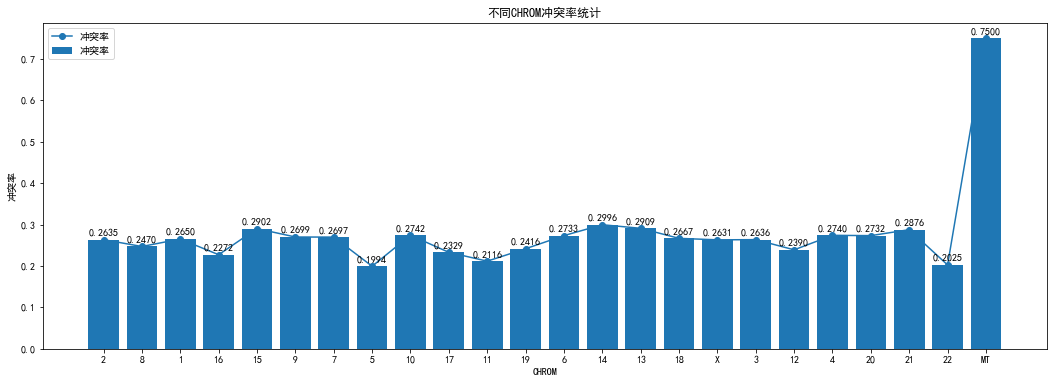

In [31]:
# 探索CHROM与冲突率
sg = df_train["CHROM"].drop_duplicates().values
sg_mr = [len(df_train[df_train['CHROM']==sg[i]][df_train['CLASS']==1])/len(df_train[df_train['CHROM']==sg[i]]) for i in range(len(sg))]
plt.figure(figsize=(18,6))
plt.plot(sg, sg_mr, 'o-', label="冲突率")
plt.bar(sg, sg_mr, label="冲突率")
plt.legend()
plt.title('不同CHROM冲突率统计')
plt.xlabel('CHROM')
plt.ylabel('冲突率')
for x, y in enumerate(sg_mr):
    plt.text(x,y+0.01,'{:.4f}'.format(y),ha='center')

#### 探索Consequence与冲突率

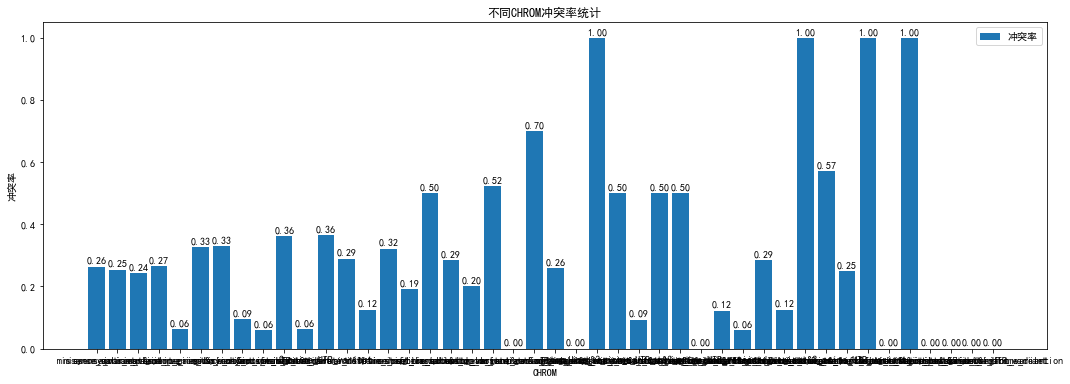

In [32]:
# 探索Consequence与冲突率
sg = df_train["Consequence"].drop_duplicates().values
sg_mr = [len(df_train[df_train['Consequence']==sg[i]][df_train['CLASS']==1])/len(df_train[df_train['Consequence']==sg[i]]) for i in range(len(sg))]
plt.figure(figsize=(18,6))
plt.bar(sg, sg_mr, label="冲突率")
plt.legend()
plt.title('不同CHROM冲突率统计')
plt.xlabel('CHROM')
plt.ylabel('冲突率')
for x, y in enumerate(sg_mr):
    plt.text(x,y+0.01,'{:.2f}'.format(y),ha='center')

#### 探索IMPACT与冲突率

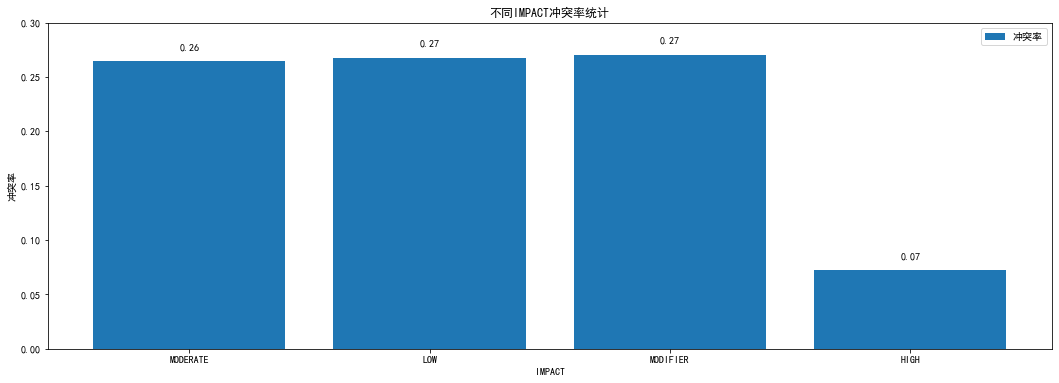

In [33]:
# 探索IMPACT与冲突率
sg = df_train["IMPACT"].drop_duplicates().values
sg_mr = [len(df_train[df_train['IMPACT']==sg[i]][df_train['CLASS']==1])/len(df_train[df_train['IMPACT']==sg[i]]) for i in range(len(sg))]
plt.figure(figsize=(18,6))
plt.bar(sg, sg_mr, label="冲突率")
plt.legend()
plt.title('不同IMPACT冲突率统计')
plt.xlabel('IMPACT')
plt.ylabel('冲突率')
plt.ylim([0, 0.3])
for x, y in enumerate(sg_mr):
    plt.text(x,y+0.01,'{:.2f}'.format(y),ha='center')

### 2.2.2相关性分析

<AxesSubplot:>

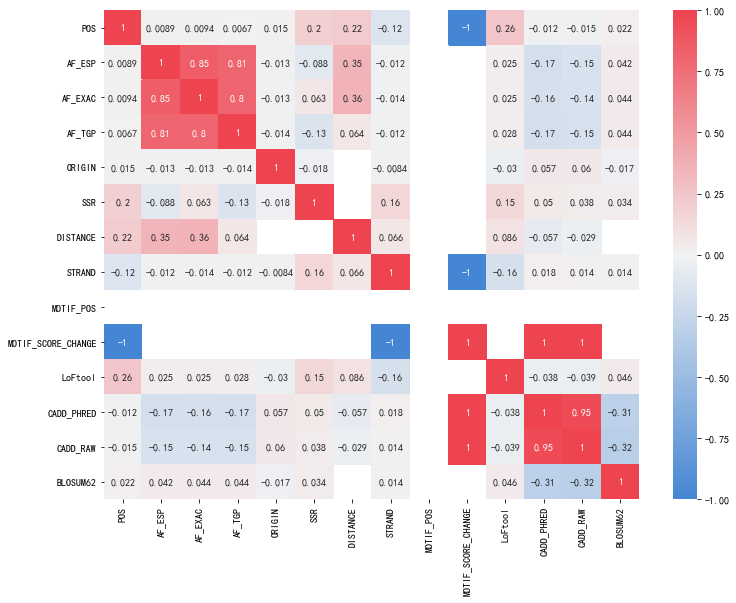

In [34]:
# 画相关系数热力图
corrmat = Xtrain.corr()
plt.figure(figsize=(12,9))
cmap=sns.diverging_palette(250,10,s=80,l=55,n=9,as_cmap=True)
sns.heatmap(corrmat,annot=True,cmap=cmap,center=0)

### 2.2.3探索AF_ESP、AF_EXAC、AF_TGP

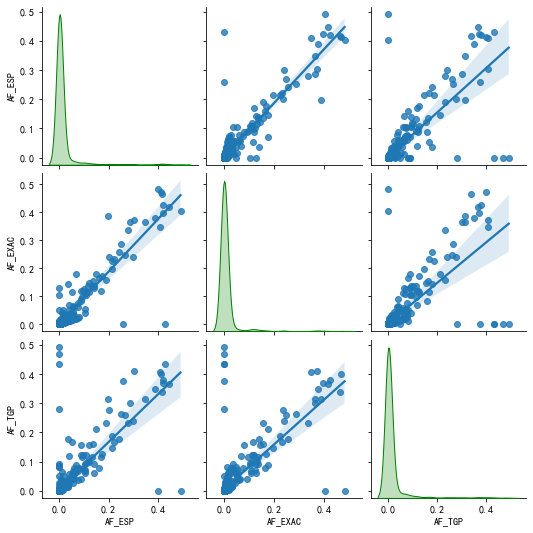

In [35]:
new_data = Xtrain[['AF_ESP','AF_EXAC','AF_TGP']][:1000]
sns.pairplot(new_data, kind = 'reg',diag_kind='kde',palette ='husl', diag_kws=dict(shade = True, color = 'g'))

### 2.2.4探索CLNVC与POS的数量分布

Text(0.5, 0, 'CLNVC')

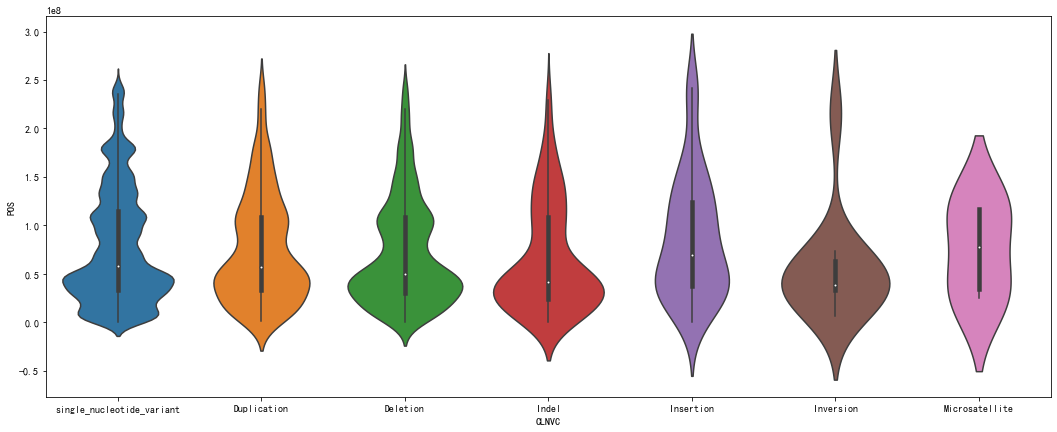

In [36]:
plt.figure(figsize = (18, 7))
sns.violinplot(x = Xtrain['CLNVC'],y = Xtrain['POS'])
plt.xlabel("")
plt.ylabel("POS")
plt.xlabel("CLNVC")

## 2.3多变量分析

### 2.3.1探索CADD_PHRED、CADD_RAW与是否冲突

<Figure size 1080x432 with 0 Axes>

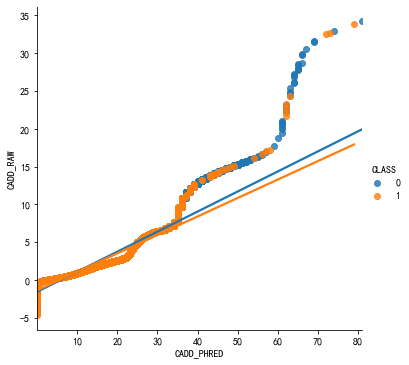

In [37]:
plt.figure(figsize=(15,6))
sns.lmplot(x='CADD_PHRED',y='CADD_RAW',ci=60,hue='CLASS',data=df_train)

### 2.3.2探索AF_ESP、AF_TGP与是否冲突

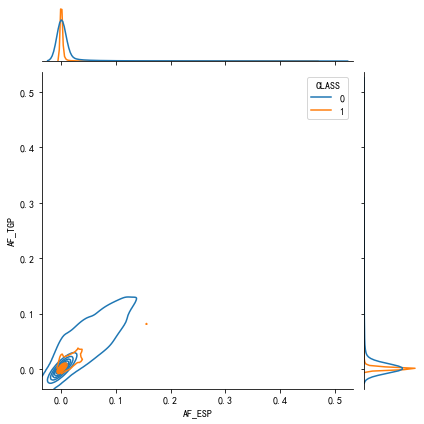

In [38]:
sns.jointplot(data=df_train, x="AF_ESP", y="AF_TGP", hue="CLASS", kind="kde")

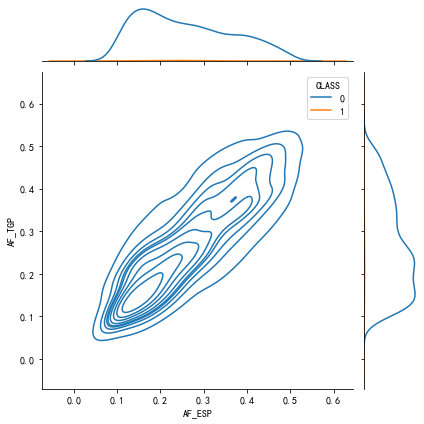

In [39]:
sns.jointplot(data=df_train.loc[(df_train['AF_ESP']>0.1) & (df_train['AF_TGP']>0.1)], x="AF_ESP", y="AF_TGP", hue="CLASS", kind="kde")

# 3.数据预处理

## 3.1删除唯一值

In [40]:
Xtrain = Xtrain.drop(['MOTIF_POS','HIGH_INF_POS'], axis=1)
Xtest = Xtest.drop(['MOTIF_POS','HIGH_INF_POS'], axis=1)

## 3.2初步处理缺失值

### 3.2.1丢弃部分特征

In [41]:
lt = []
for i in range(len(Xtrain.columns)):
    if Xtrain[Xtrain.columns[i]].isnull().sum()/len(Xtrain)<0.2:
        print(Xtrain[Xtrain.columns[i]].isnull().sum()/len(Xtrain))
        lt.append(Xtrain.columns[i])
Xtrain = Xtrain[[lt[i] for i in range(len(lt))]]
Xtest = Xtest[[lt[i] for i in range(len(lt))]]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.012842146786176064
0.0
0.0
0.0
0.0
0.00026297911507527775
0.00021914926256273148
0.00021914926256273148
0.00026297911507527775
0.137034033880476
0.13690254432293836
0.15423725099165042
0.15423725099165042
0.15491661370559487
0.15491661370559487
0.00021914926256273148
0.06469286230851833
0.01678683351230523
0.01678683351230523


### 3.2.2处理分类型缺失值

In [42]:
# 筛选数值型特征
numerical_fea = list(Xtrain.select_dtypes(exclude=['object']).columns)
# 筛选分类型变量
category_fea = list(filter(lambda x: x not in numerical_fea,list(Xtrain.columns)))
print('分类型变量：')
dic = {}
for i in range(len(category_fea)):
    if Xtrain[category_fea[i]].isnull().sum()/len(Xtrain) != 0:
        dic[category_fea[i]] = Xtrain[category_fea[i]].isnull().sum()/len(Xtrain)
pd.DataFrame(dic, index=[0])

分类型变量：


,MC,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons
0,0.012842,0.000263,0.000219,0.000219,0.000263,0.137034,0.136903,0.154237,0.154237,0.154917,0.154917


In [43]:
# 用众数填补分类型变量缺失值
for i in range(len(category_fea)):
    Xtrain[category_fea[i]] = Xtrain[category_fea[i]].fillna(Xtrain[category_fea[i]].mode()[0])
    Xtest[category_fea[i]] = Xtest[category_fea[i]].fillna(Xtrain[category_fea[i]].mode()[0])

## 3.3特征编码

In [44]:
print(category_fea)

['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC', 'MC', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons']


### 3.3.1顺序编码

In [45]:
# CHROM顺序编码
dic = {}
for i in range(22):
    dic[str(i+1)] = i+1
dic['X']=23
dic['MT']=24
Xtrain['CHROM'] = Xtrain['CHROM'].apply(lambda x : dic[x])
Xtest['CHROM'] = Xtest['CHROM'].apply(lambda x : dic[x])

### 3.3.2均值编码

In [46]:
# 高基数无序特征均值编码
mean_fea = ['REF','ALT','CLNDISDB','CLNDN','CLNHGVS','MC','Allele','Consequence','SYMBOL','Feature','Amino_acids','Codons']
for i in range(len(mean_fea)):
    print(mean_fea[i], '的种类数为：', Xtrain[mean_fea[i]].drop_duplicates().count())

REF 的种类数为： 661
ALT 的种类数为： 346
CLNDISDB 的种类数为： 7504
CLNDN 的种类数为： 7519
CLNHGVS 的种类数为： 45631
MC 的种类数为： 84
Allele 的种类数为： 289
Consequence 的种类数为： 44
SYMBOL 的种类数为： 2202
Feature 的种类数为： 2234
Amino_acids 的种类数为： 995
Codons 的种类数为： 1796


In [47]:
for i in range(len(mean_fea)):
    means = df_train.groupby(mean_fea[i])['CLASS'].mean()
    Xtrain[mean_fea[i]] = Xtrain[mean_fea[i]].map(means)
for i in range(len(mean_fea)):
    means = df_test.groupby(mean_fea[i])['CLASS'].mean()
    Xtest[mean_fea[i]] = Xtest[mean_fea[i]].map(means)

### 3.3.3独热编码

In [48]:
# 特征独热编码
onehot_fea = ['CLNVC', 'IMPACT', 'Feature_type', 'BIOTYPE']
for i in range(len(onehot_fea)):
    print(onehot_fea[i], '的种类数为：', Xtrain[onehot_fea[i]].drop_duplicates().count())

CLNVC 的种类数为： 7
IMPACT 的种类数为： 4
Feature_type 的种类数为： 2
BIOTYPE 的种类数为： 2


In [49]:
Xtrain = pd.get_dummies(Xtrain, columns=['CLNVC', 'IMPACT', 'Feature_type', 'BIOTYPE'])
Xtest = pd.get_dummies(Xtest, columns=['CLNVC', 'IMPACT', 'Feature_type', 'BIOTYPE'])
Xtest['Feature_type_MotifFeature'] = [0 for i in range(len(Xtest))] #为了与训练集保持一致，添加一列

## 3.4其余特征处理

In [50]:
Xtrain[['EXON', 'cDNA_position', 'CDS_position', 'Protein_position']].head()

,EXON,cDNA_position,CDS_position,Protein_position
0,358/363,105139,104914,34972
1,8/11,1256,1255,419
2,21/22,2936,2871,957
3,5/11,1198,854,285
4,2/11,712,237,79


In [51]:
# 其他处理 EXON
for i in range(len(Xtrain)):
    if Xtrain['EXON'][i] != 0:
        Xtrain['EXON'][i] = np.dtype('float64').type(int(Xtrain['EXON'][i].split("/")[0]) / int(Xtrain['EXON'][i].split("/")[1]))
for i in range(len(Xtest)):
    if Xtest['EXON'][i] != 0:
        Xtest['EXON'][i] = np.dtype('float64').type(int(Xtest['EXON'][i].split("/")[0]) / int(Xtest['EXON'][i].split("/")[1]))
numerical_fea.append('EXON')
Xtrain['EXON'] = Xtrain['EXON'].astype('float64')
Xtest['EXON'] = Xtest['EXON'].astype('float64')

In [52]:
# 其他处理 cDNA_position
for i in range(len(Xtrain)):
    if Xtrain['cDNA_position'][i].split('-')[0].isdigit():
        Xtrain['cDNA_position'][i] = np.dtype('int64').type(int(Xtrain['cDNA_position'][i].split('-')[0]))
    else:
        Xtrain['cDNA_position'][i] = np.dtype('int64').type(int(Xtrain['cDNA_position'][i].split('-')[1]))
for i in range(len(Xtest)):
    if Xtest['cDNA_position'][i].split('-')[0].isdigit():
        Xtest['cDNA_position'][i] = np.dtype('int64').type(int(Xtest['cDNA_position'][i].split('-')[0]))
    else:
        Xtest['cDNA_position'][i] = np.dtype('int64').type(int(Xtest['cDNA_position'][i].split('-')[1]))
numerical_fea.append('cDNA_position')
Xtrain['cDNA_position'] = Xtrain['cDNA_position'].astype('int64')
Xtest['cDNA_position'] = Xtest['cDNA_position'].astype('int64')

In [53]:
# 其他处理 CDS_position
for i in range(len(Xtrain)):
    if Xtrain['CDS_position'][i].split('-')[0].isdigit():
        Xtrain['CDS_position'][i] = np.dtype('int64').type(int(Xtrain['CDS_position'][i].split('-')[0]))
    else:
        Xtrain['CDS_position'][i] = np.dtype('int64').type(int(Xtrain['CDS_position'][i].split('-')[1]))
for i in range(len(Xtest)):
    if Xtest['CDS_position'][i].split('-')[0].isdigit():
        Xtest['CDS_position'][i] = np.dtype('int64').type(int(Xtest['CDS_position'][i].split('-')[0]))
    else:
        Xtest['CDS_position'][i] = np.dtype('int64').type(int(Xtest['CDS_position'][i].split('-')[1]))
numerical_fea.append('CDS_position')
Xtrain['CDS_position'] = Xtrain['CDS_position'].astype('int64')
Xtest['CDS_position'] = Xtest['CDS_position'].astype('int64')

In [54]:
# 其他处理 Protein_position
for i in range(len(Xtrain)):
    if Xtrain['Protein_position'][i].split('-')[0].isdigit():
        Xtrain['Protein_position'][i] = np.dtype('int64').type(int(Xtrain['Protein_position'][i].split('-')[0]))
    else:
        Xtrain['Protein_position'][i] = np.dtype('int64').type(int(Xtrain['Protein_position'][i].split('-')[1]))
for i in range(len(Xtest)):
    if Xtest['Protein_position'][i].split('-')[0].isdigit():
        Xtest['Protein_position'][i] = np.dtype('int64').type(int(Xtest['Protein_position'][i].split('-')[0]))
    else:
        Xtest['Protein_position'][i] = np.dtype('int64').type(int(Xtest['Protein_position'][i].split('-')[1]))
numerical_fea.append('Protein_position')
Xtrain['Protein_position'] = Xtrain['Protein_position'].astype('int64')
Xtest['Protein_position'] = Xtest['Protein_position'].astype('int64')

# 3.5处理数值型缺失值

In [55]:
# 筛选数值型特征
print('数值型变量：')
dic={}
for i in range(len(numerical_fea)):
    if Xtrain[numerical_fea[i]].isnull().sum()/len(Xtrain) != 0:
        dic[numerical_fea[i]] = Xtrain[numerical_fea[i]].isnull().sum()/len(Xtrain)
n_dic = sorted(dic.items(), key=operator.itemgetter(1))
nn_dic = {}
for i in range(len(n_dic)):
    nn_dic[n_dic[i][0]] = n_dic[i][1]
num = pd.DataFrame(nn_dic, index=[0])
num

数值型变量：


,STRAND,CADD_PHRED,CADD_RAW,LoFtool
0,0.000219,0.016787,0.016787,0.064693


In [56]:
sortindex = []
for i in range(len(num.columns)):
    sortindex.append(np.where(Xtrain.columns==num.columns[i])[0][0])
for i in sortindex:
    df = Xtrain
    fillc = df.iloc[:,i]
    df = df.iloc[:,df.columns != i]
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
    ytrain = fillc[fillc.notnull()]
    ytest = fillc[fillc.isnull()]
    xtrain = df_0[ytrain.index,:]
    xtest = df_0[ytest.index,:]
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(xtrain, ytrain)
    ypredict = rfc.predict(xtest)
    Xtrain.loc[Xtrain.iloc[:,i].isnull(),Xtrain.columns[i]] = ypredict
for i in sortindex:
    df = Xtest
    fillc = df.iloc[:,i]
    df = df.iloc[:,df.columns != i]
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
    ytrain = fillc[fillc.notnull()]
    ytest = fillc[fillc.isnull()]
    xtrain = df_0[ytrain.index,:]
    xtest = df_0[ytest.index,:]
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(xtrain, ytrain)
    ypredict = rfc.predict(xtest)
    Xtest.loc[Xtest.iloc[:,i].isnull(),Xtest.columns[i]] = ypredict

## 3.6异常值处理

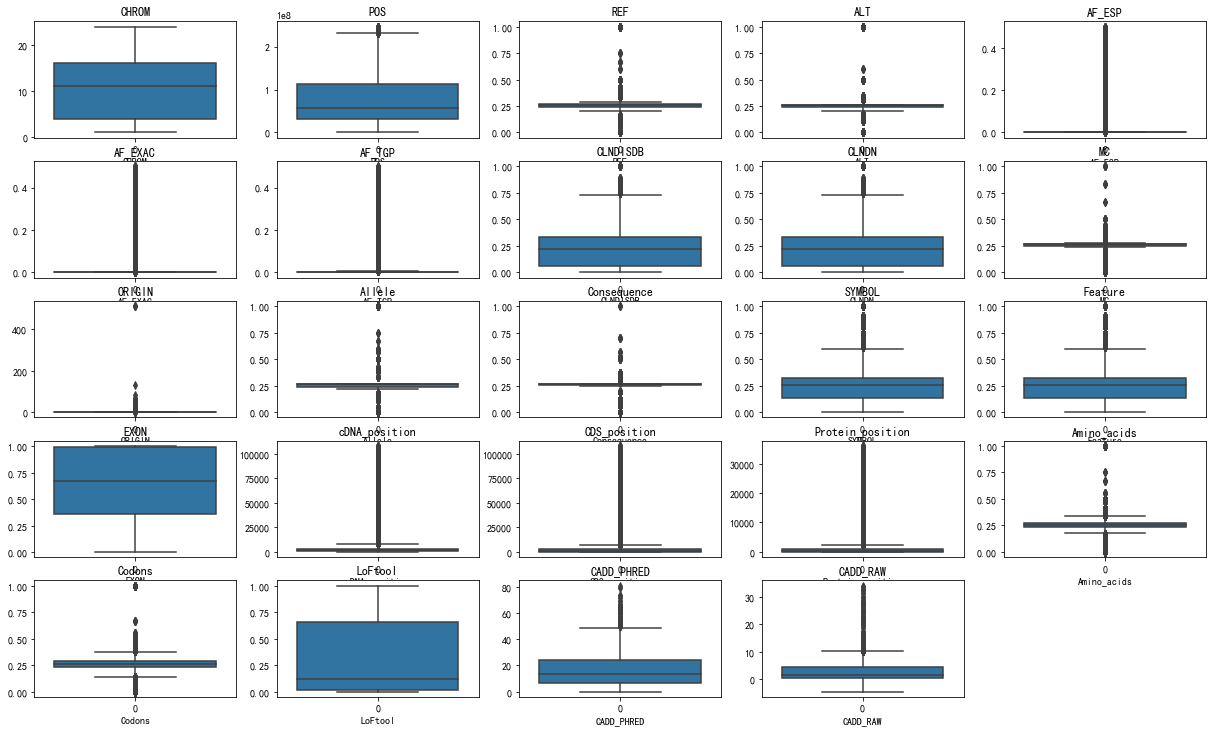

In [57]:
l = list(Xtrain.select_dtypes(exclude=['object']).columns)[:-15]
l.remove('CLNHGVS') # 只有2个取值
l.remove('STRAND') # 只有2个取值
plt.figure(3, figsize=(21,15))
for i in range(len(l)):
    plt.subplot(6, 5, i+1)
    sns.boxplot(data=Xtrain[l[i]])
    plt.title(l[i])
    plt.xlabel(l[i])
plt.show()

## 3.7样本重采样

In [58]:
# 对标签为0的样本进行欠采样
idx_0 = df_train[df_train['CLASS'] == 0].index.values
idx_1 = df_train[df_train['CLASS'] == 1].index.values
random.shuffle(idx_0)
Xtrain = Xtrain.drop(idx_0[0:int((len(idx_0)-len(idx_1))/2)])
Ytrain = Ytrain.drop(idx_0[0:int((len(idx_0)-len(idx_1))/2)])

# 4.特征工程

## 4.1特征构造

In [59]:
Xtrain['AF_AVG'] = (Xtrain['AF_ESP']+Xtrain['AF_EXAC']+Xtrain['AF_TGP'])/3
Xtrain['CADD_SCORE'] = (Xtrain['CADD_PHRED']+Xtrain['CADD_RAW'])/2
Xtrain.shape

(34337, 43)

In [60]:
Xtest['AF_AVG'] = (Xtest['AF_ESP']+Xtest['AF_EXAC']+Xtest['AF_TGP'])/3
Xtest['CADD_SCORE'] = (Xtest['CADD_PHRED']+Xtest['CADD_RAW'])/2
Xtest.shape

(19557, 43)

## 4.2特征降维

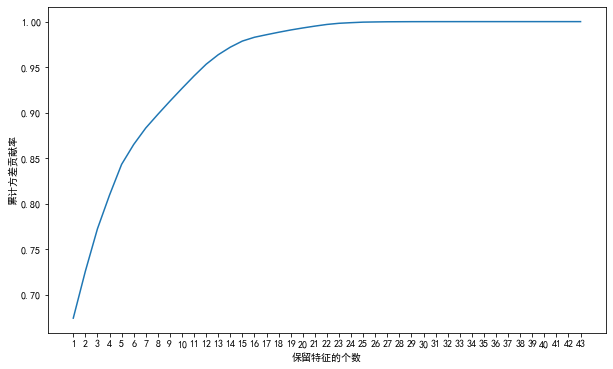

In [61]:
ss = StandardScaler()
ss = ss.fit(Xtrain.loc[:,l])
Xtrain.loc[:,l] = ss.transform(Xtrain.loc[:,l])
Xtest.loc[:,l] = ss.transform(Xtest.loc[:,l])
pca_line = PCA().fit(Xtrain)
plt.figure(figsize=(10,6))
plt.plot([i+1 for i in range(43)],np.cumsum(pca_line.explained_variance_ratio_))
plt.xticks([i+1 for i in range(43)])
plt.xlabel("保留特征的个数")
plt.ylabel("累计方差贡献率")
plt.show()

In [62]:
# 找到可以解释98%的pca
pca = PCA(n_components=0.98,svd_solver="full")
txa = pca.fit(Xtrain).transform(Xtrain)
Xtest = pca.fit(Xtrain).transform(Xtest)
Xtrain = pd.DataFrame(txa)
Xtest = pd.DataFrame(Xtest)
print(Xtrain.shape)
print(Xtest.shape)

(34337, 16)
(19557, 16)


In [63]:
# 压缩数据，否则占用内存过多，运行失败
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2    
    print("转换前的占用的内存为：", start_mem, "MB")
    for col in df.columns:
        df[col] = df[col].astype(np.float16)
    end_mem = df.memory_usage().sum() / 1024**2
    print("转换后的占用的内存为：", end_mem, "MB")
    print('压缩率为：{:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
Xtrain = reduce_mem_usage(Xtrain)

转换前的占用的内存为： 4.191650390625 MB
转换后的占用的内存为： 1.048004150390625 MB
压缩率为：75.0%


# 5.模型构建与调参

## 5.1初始模型评估

In [64]:
def cv_score_train_test(model):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    score_list = ["accuracy","f1", "roc_auc"]
    train_scores = []
    test_scores = []
    for score in score_list:
        train_scores.append(cross_val_score(model, Xtrain, Ytrain, cv=kfold, scoring=score).mean())
        test_scores.append(cross_val_score(model, Xtest, Ytest, cv=kfold, scoring=score).mean())
    scores = np.array((train_scores + test_scores)).reshape(2, -1)
    scores_df = pd.DataFrame(scores, index=['Train', 'Test'], columns=score_list)
    print(scores_df)

In [130]:
#未进行调参时的模型
xgb_clf1 = XGBClassifier(seed=27)
xgb_clf1.fit(Xtrain, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [138]:
y_pred_origin = xgb_clf1.predict(Xtest)
y_pre_origin = [round(value) for value in y_pred_origin]

print('XGBoost分类报告')
print("Accuracy:", accuracy_score(Ytest,y_pre_origin))
print("F1 Score:", f1_score(Ytest,y_pre_origin, average='weighted'))
print(classification_report(Ytest, y_pre_origin))

XGBoost分类报告
Accuracy: 0.8836222324487396
F1 Score: 0.885968123157336
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     14644
           1       0.74      0.84      0.78      4913

    accuracy                           0.88     19557
   macro avg       0.84      0.87      0.85     19557
weighted avg       0.89      0.88      0.89     19557



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

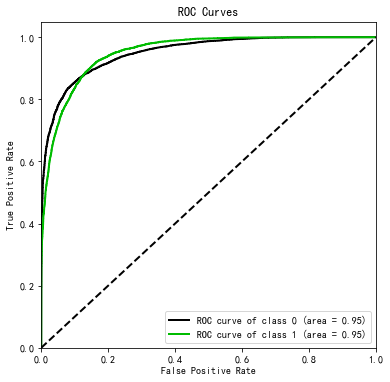

In [132]:
vali_proba_df = pd.DataFrame(xgb_clf1.predict_proba(Xtest))
skplt.metrics.plot_roc(Ytest, vali_proba_df,
                        plot_micro=False,figsize=(6,6),
                        plot_macro=False)

In [195]:
# 查看此时的模型效果
cv_score_train_test(xgb_clf1)

       accuracy        f1   roc_auc
Train  0.880945  0.817441  0.947922
Test   0.891138  0.770741  0.947708


## 5.2模型调参

### 5.2.1调n_estimators，初步调learning_rate

In [147]:
#其他参数设置为默认值
model1_1 = XGBClassifier(objective= 'binary:logistic',nthread=4,seed=27)
#网格搜索参数列表
learning_rate = [0.001, 0.01, 0.1, 0.2]
n_estimators = [100, 200, 300, 500, 1000, 1500]
param1 = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表

grid_search = GridSearchCV(model1_1, param_grid=param1, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(Xtrain, Ytrain)

print("最高得分: %f 参数 %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
最高得分: 0.965616 参数 {'learning_rate': 0.2, 'n_estimators': 1500}


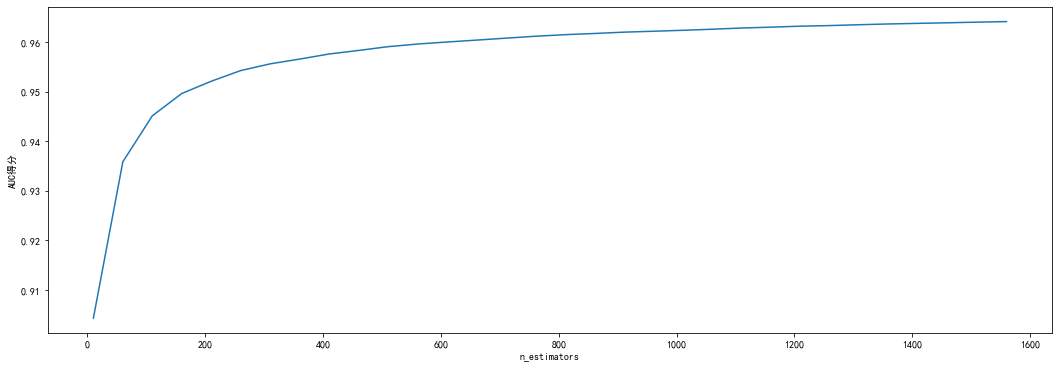

得分最高为： 0.9657835708428876 此时的n_estimators为： 1560


In [91]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
axisx = range(10,1601,50)
rs = []
for i in axisx:
    reg = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=i,seed=27,learning_rate=0.2)
    rs.append(cross_val_score(reg,Xtrain,Ytrain,cv=kfold,scoring="roc_auc").mean())
plt.figure(figsize = (18, 6))
plt.plot(range(10,1600,50), rs)
plt.xlabel('n_estimators')
plt.ylabel('AUC得分')
plt.show()
print('得分最高为：', max(rs), '此时的n_estimators为：', axisx[rs.index(max(rs))])

In [196]:
# 这里取n_estimators=900
model1_2 = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,learning_rate=0.2)
# 查看此时的模型效果
cv_score_train_test(model1_2)

       accuracy        f1   roc_auc
Train  0.904826  0.854950  0.963740
Test   0.899678  0.789653  0.954753


### 5.2.2调max_depth、min_child_weight

In [151]:
#其他参数设置为默认值
model2 = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,learning_rate=0.2)

max_depth = [3, 5, 6, 7, 9, 12, 15, 17, 25]
min_child_weight = [1, 3, 5, 7]
param2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
# k折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model2, param_grid=param2, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(Xtrain, Ytrain)

print("最高得分: %f 参数 %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最高得分: 0.964833 参数 {'max_depth': 9, 'min_child_weight': 7}


In [197]:
# 查看此时的模型效果
model = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                      learning_rate=0.2,max_depth=9,min_child_weight=7)
cv_score_train_test(model)

       accuracy        f1   roc_auc
Train  0.906398  0.857928  0.964833
Test   0.899678  0.790227  0.956203


### 5.2.3调gamma

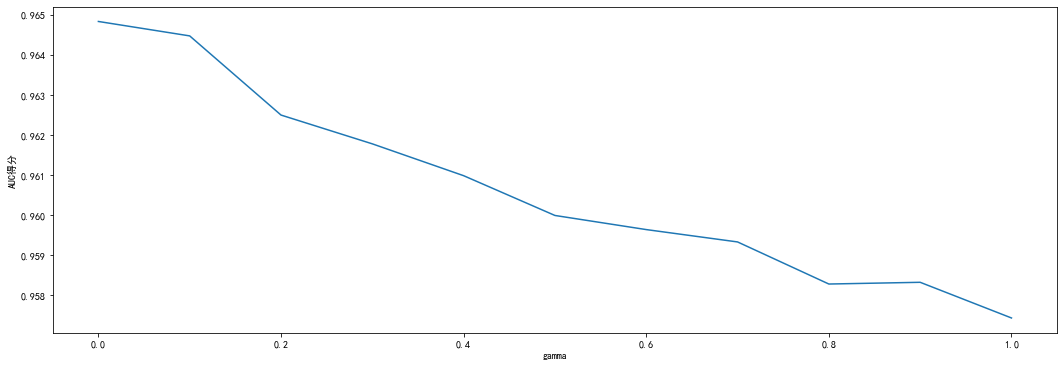

得分最高为： 0.9648327971998866 此时的gamma为： 0


In [178]:
axisx = np.linspace(0, 1, 11)
rs = []
for i in axisx:
    reg = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=i)
    rs.append(cross_val_score(reg,Xtrain,Ytrain,cv=kfold,scoring="roc_auc").mean())
plt.figure(figsize = (18, 6))
plt.plot(axisx, rs)
plt.xlabel('gamma')
plt.ylabel('AUC得分')
plt.show()
print('得分最高为：', max(rs), '此时的gamma为：', axisx[rs.index(max(rs))])

In [198]:
# 查看此时的模型效果
model = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=0)
cv_score_train_test(model)

       accuracy        f1   roc_auc
Train  0.906398  0.857928  0.964833
Test   0.899678  0.790227  0.956203


### 5.2.4.调subsample、colsample_bytree

In [183]:
model4 = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=0)

subsample = [ i/10.0 for i in range(6, 11)]
colsample_bytree  =  [ i/10.0 for i in range(6, 11)]
param4 = dict(subsample=subsample, colsample_bytree=colsample_bytree)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model4, param_grid=param4, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(Xtrain, Ytrain)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
最高得分: 0.964928 参数 {'colsample_bytree': 1.0, 'subsample': 0.9}


In [184]:
colsample_bytree  =  [ i/100.0 for i in range(80,101,5)]
subsample = [ i/100.0 for i in range(80,101,5)]
param4_2 = dict(subsample=subsample, colsample_bytree=colsample_bytree)

grid_search = GridSearchCV(model4, param_grid=param4_2, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(Xtrain, Ytrain)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
最高得分: 0.965601 参数 {'colsample_bytree': 1.0, 'subsample': 0.85}


In [199]:
model = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,learning_rate=0.2,
                      max_depth=9,min_child_weight=7,gamma=0,colsample_bytree=1.0,subsample=0.85)
cv_score_train_test(model)

       accuracy        f1   roc_auc
Train  0.907738  0.860135  0.965601
Test   0.900854  0.794229  0.955794


### 5.2.5调正则化参数reg_alpha、reg_lambda

In [185]:
model5 = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=0,colsample_bytree=1,subsample=0.85)

reg_alpha = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,1]
reg_lambda  =  [0,0.1,0.5,1]
param5 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model5, param_grid=param5, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(Xtrain, Ytrain)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
最高得分: 0.965601 参数 {'reg_alpha': 0, 'reg_lambda': 1}


In [200]:
model = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=0,
                        colsample_bytree=1,subsample=0.85,reg_alpha=0,reg_lambda=1)
cv_score_train_test(model)

       accuracy        f1   roc_auc
Train  0.907738  0.860135  0.965601
Test   0.900854  0.794229  0.955794


### 5.2.6重新调整learning_rate

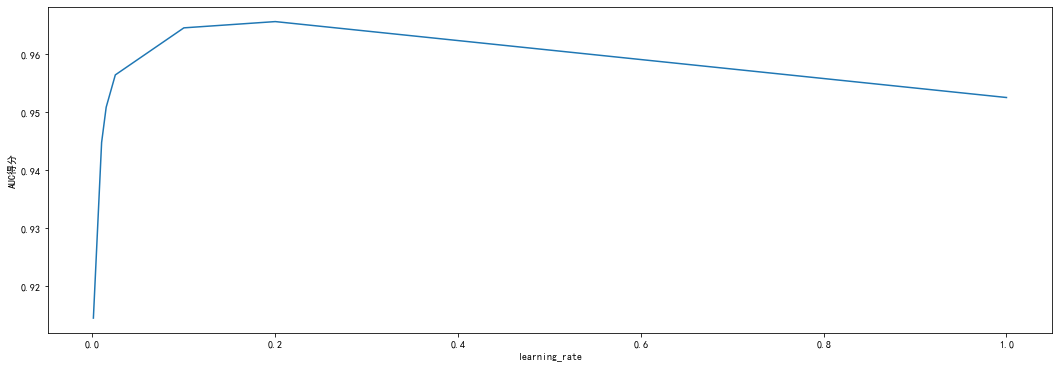

得分最高为： 0.9656009874804887 此时的learning_rate为： 0.2


In [189]:
axisx = [0.001, 0.01, 0.015, 0.025, 0.1, 0.2, 1]
rs = []
for i in axisx:
    reg = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=i,max_depth=9,min_child_weight=7,gamma=0,
                        colsample_bytree=1,subsample=0.85,reg_alpha=0,reg_lambda=1)
    rs.append(cross_val_score(reg,Xtrain,Ytrain,cv=kfold,scoring="roc_auc").mean())
plt.figure(figsize = (18, 6))
plt.plot(axisx, rs)
plt.xlabel('learning_rate')
plt.ylabel('AUC得分')
plt.show()
print('得分最高为：', max(rs), '此时的learning_rate为：', axisx[rs.index(max(rs))])

## 5.3模型评估

In [190]:
final = XGBClassifier(objective= 'binary:logistic',nthread=8,n_estimators=900,seed=27,
                        learning_rate=0.2,max_depth=9,min_child_weight=7,gamma=0,
                        colsample_bytree=1,subsample=0.85,reg_alpha=0,reg_lambda=1)
final.fit(Xtrain, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=8, nthread=8, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.85, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [191]:
y_pred = final.predict(Xtest)
y_presult = [round(value) for value in y_pred]

print('XGBoost模型分类报告')
print("Accuracy:", accuracy_score(Ytest,y_presult))
print("F1 Score:", f1_score(Ytest,y_presult, average='weighted'))
print(classification_report(Ytest, y_presult))

XGBoost模型分类报告
Accuracy: 0.8913943856419696
F1 Score: 0.8940947692150215
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     14644
           1       0.74      0.87      0.80      4913

    accuracy                           0.89     19557
   macro avg       0.85      0.88      0.86     19557
weighted avg       0.90      0.89      0.89     19557



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

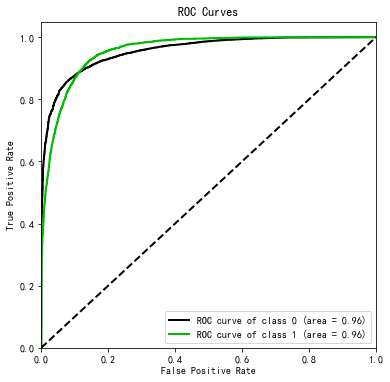

In [192]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(final.predict_proba(Xtest))
skplt.metrics.plot_roc(Ytest, vali_proba_df,
                        plot_micro=False,figsize=(6,6),
                        plot_macro=False)

Text(53.0, 0.5, '真实值')

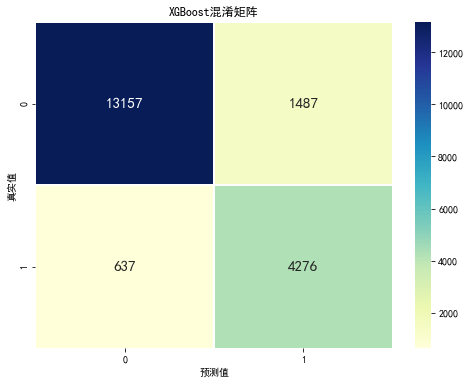

In [202]:
f, ax = plt.subplots(figsize=(8,6))
C = confusion_matrix(Ytest, y_presult, labels=[0, 1])
sns.heatmap(C, annot=True, fmt='.0f',ax=ax, linewidths=.5, cmap="YlGnBu",annot_kws={'size':15})
ax.set_title('XGBoost混淆矩阵')
ax.set_xlabel('预测值')
ax.set_ylabel('真实值')